# Set up 

## Check Environment 

In [75]:
import boto3

region = boto3.Session().region_name
session = boto3.session.Session()

ec2 = boto3.Session().client(service_name="ec2", region_name=region)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

## Update IAM Roles and Policies

In [76]:
import sagemaker
import time
from time import gmtime, strftime

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

from botocore.config import Config

config = Config(retries={"max_attempts": 10, "mode": "adaptive"})

iam = boto3.client("iam", config=config)

In [77]:
role_name = role.split("/")[-1]

print("Role name: {}".format(role_name))

Role name: LabRole


## Import Libraries

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
! pip install descartes
! pip install geopandas
!pip install wordcloud
import geopandas as gpd
from geopandas import GeoDataFrame, points_from_xy
from wordcloud import WordCloud

In [79]:
s3_public_path = "s3://sagemaker-studio-458903497716-h2kl4ff3dz/data"

In [80]:
%store s3_public_path

Stored 's3_public_path' (str)


In [81]:
s3_private_path = "s3://{}/gunData".format(bucket)
s3_private_path

's3://sagemaker-us-east-1-458903497716/gunData'

In [82]:
%store s3_private_path

Stored 's3_private_path' (str)


In [83]:
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --include "*" 

copy: s3://sagemaker-studio-458903497716-h2kl4ff3dz/data/gun_violence.csv to s3://sagemaker-us-east-1-458903497716/gunData/gun_violence.csv


# Create Database Schema in Athena

In [84]:
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = '{}/gunData'.format(bucket)
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
bucket

'sagemaker-us-east-1-458903497716/gunData'

In [85]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [86]:
#assign database name
database_name = "ads508"

In [87]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [88]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [89]:
#create new database 'ads508'
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
create_db = pd.read_sql(statement, conn)
create_db

""


In [90]:
#verify database creation
q = "SHOW DATABASES"
db_show = pd.read_sql(q, conn)
db_show

,database_name
0,ads508
1,default
2,dsoaws


## Create Athena Table

In [91]:
# Set Athena parameters
database_name = "ads508"
table_name_csv = "gun_violence"
s3_path = "s3://{}/data".format(bucket)
print(s3_path)

s3://sagemaker-us-east-1-458903497716/gunData/data


In [92]:
# SQL statement to execute
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         incident_id int,
         date date,
         state string,
         city_or_county string,
         address string,
         n_killed int,
         n_injured int,
         incident_url string,
         source_url string,
         incident_url_fields_missing string,
         congressional_district int,
         gun_stolen string,
         gun_type string,
         incident_characteristics string,
         latitude int,
         location_description string,
         longitude int,
         n_guns_involved int,
         notes string,
         participant_age string,
         participant_age_group string,
         participant_gender string,
         participant_name string,
         participant_relationship string,
         participant_status string,
         participant_type string,
         sources string,
         state_house_district int,
         state_senate_district int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_path
)

create_table = pd.read_sql(statement, conn)
create_table

""


In [93]:
statement = "SHOW TABLES in ads508"
tables = pd.read_sql(statement, conn)
tables

,tab_name
0,gun_violence


In [94]:
statement = "SELECT * from ads508.gun_violence LIMIT 100"
df = pd.read_sql(statement, conn)
df.head(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,325922.0,2015-02-19,Oregon,Portland,NE Cleveland and NE Dekum,0.0,0.0,http://www.gunviolencearchive.org/incident/325922,http://koin.com/2015/02/19/car-damaged-in-ne-p...,False,...,,,,,,,,,NaN,43.0
1,295092.0,2015-02-19,Virginia,Richmond,1400 block of Ivymount Road,0.0,2.0,http://www.gunviolencearchive.org/incident/295092,http://wric.com/2015/02/19/ric-shooting/,False,...,"2 men shot each other""",,0::Adult 18+||1::Adult 18+,0::Male||1::Male,,,0::Injured||1::Injured,0::Victim||1::Victim,NaN,69.0
2,323251.0,2015-02-19,Connecticut,Jewett City,24 Maple Street,0.0,0.0,http://www.gunviolencearchive.org/incident/323251,http://www.norwichbulletin.com/article/2015041...,False,...,various raids,selling drugs to undercover,243 cal rifle and 50 cal black powder rifle f...,0::51,0::Adult 18+,0::Male,0::Allan Benoit,,NaN,NaN
3,295080.0,2015-02-19,Oklahoma,Delaware County,,0.0,1.0,http://www.gunviolencearchive.org/incident/295080,http://www.kjrh.com/news/local-news/shooting-r...,False,...,0::33,0::Adult 18+||1::Adult 18+,0::Female,0::Dana Beckett,,0::Injured||1::Unharmed,0::Victim||1::Subject-Suspect,http://www.tulsaworld.com/homepagelatest/delaw...,5.0,1.0
4,295562.0,2015-02-19,New York,Bronx,1023 East 217th Street,1.0,0.0,http://www.gunviolencearchive.org/incident/295562,http://www.nydailynews.com/new-york/nyc-crime/...,False,...,,"""Williamsburg",found dead in car,"shot in torso""",0::44,0::Adult 18+||1::Adult 18+||2::Adult 18+,0::Male||1::Male||2::Male,0::Paul Dwyer,NaN,NaN


# Insert Dataset into Pandas Dataframe

In [95]:
df = pd.read_csv("s3://sagemaker-studio-458903497716-h2kl4ff3dz/data/gun_violence.csv")
df.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


In [96]:
print(df.shape)

(239677, 29)


### The dataset contains 23,9677 rows and 29 attributes. 

# Data Overview

## Show data types

In [117]:
df.dtypes

incident_id                       int64
date                             object
state                            object
city_or_county                   object
address                          object
n_killed                          int64
n_injured                         int64
incident_url                     object
source_url                       object
incident_url_fields_missing        bool
congressional_district          float64
gun_stolen                       object
gun_type                         object
incident_characteristics         object
latitude                        float64
location_description             object
longitude                       float64
n_guns_involved                 float64
notes                            object
participant_age                  object
participant_age_group            object
participant_gender               object
participant_name                 object
participant_relationship         object
participant_status               object


## Show null counts

In [97]:
df.isnull().sum()

incident_id                         0
date                                0
state                               0
city_or_county                      0
address                         16497
n_killed                            0
n_injured                           0
incident_url                        0
source_url                        468
incident_url_fields_missing         0
congressional_district          11944
gun_stolen                      99498
gun_type                        99451
incident_characteristics          326
latitude                         7923
location_description           197588
longitude                        7923
n_guns_involved                 99451
notes                           81017
participant_age                 92298
participant_age_group           42119
participant_gender              36362
participant_name               122253
participant_relationship       223903
participant_status              27626
participant_type                24863
sources     

## Show percentage of null values

In [116]:
100*(df.isnull().sum())/len(df.index)

incident_id                     0.000000
date                            0.000000
state                           0.000000
city_or_county                  0.000000
address                         6.883013
n_killed                        0.000000
n_injured                       0.000000
incident_url                    0.000000
source_url                      0.195263
incident_url_fields_missing     0.000000
congressional_district          4.983373
gun_stolen                     41.513370
gun_type                       41.493760
incident_characteristics        0.136016
latitude                        3.305699
location_description           82.439283
longitude                       3.305699
n_guns_involved                41.493760
notes                          33.802576
participant_age                38.509327
participant_age_group          17.573234
participant_gender             15.171251
participant_name               51.007397
participant_relationship       93.418643
participant_stat

## Describe all numeric variables

In [109]:
df.describe()

,incident_id,n_killed,n_injured,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district
count,2.396770e+05,239677.000000,239677.000000,227733.000000,231754.000000,231754.000000,140226.000000,200905.000000,207342.00000
mean,5.593343e+05,0.252290,0.494007,8.001265,37.546598,-89.338348,1.372442,55.447132,20.47711
std,2.931287e+05,0.521779,0.729952,8.480835,5.130763,14.359546,4.678202,42.048117,14.20456
min,9.211400e+04,0.000000,0.000000,0.000000,19.111400,-171.429000,1.000000,1.000000,1.00000
25%,3.085450e+05,0.000000,0.000000,2.000000,33.903400,-94.158725,1.000000,21.000000,9.00000
50%,5.435870e+05,0.000000,0.000000,5.000000,38.570600,-86.249600,1.000000,47.000000,19.00000
75%,8.172280e+05,0.000000,1.000000,10.000000,41.437375,-80.048625,1.000000,84.000000,30.00000
max,1.083472e+06,50.000000,53.000000,53.000000,71.336800,97.433100,400.000000,901.000000,94.00000


## Describe all string variables

In [110]:
df.describe(include=[object])

,date,state,city_or_county,address,incident_url,source_url,gun_stolen,gun_type,incident_characteristics,location_description,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources
count,239677,239677,239677,223180,239677,239209,140179,140226,239351,42089,158660,147379,197558,203315,117424,15774,212051,214814,239068
unique,1725,51,12898,198037,239677,213989,349,2502,18126,27595,136652,18951,898,873,113488,284,2150,259,217280
top,2017-01-01,Illinois,Chicago,2375 International Pkwy,http://www.gunviolencearchive.org/incident/461105,http://blog.tsa.gov,0::Unknown,0::Unknown,Shot - Wounded/Injured,Austin,man shot,0::24,0::Adult 18+,0::Male,0::Officer,1::Significant others - current or former,0::Injured,0::Victim,http://blog.tsa.gov
freq,342,17556,10814,160,1,1092,121310,93559,47541,240,501,3814,94671,93496,144,2651,42293,58564,1092


# Analysis by Location

In [127]:
statement="SELECT state, count(*) as incident_count from ads508.gun_violence GROUP BY state ORDER BY count(*) DESC"
gb_state=pd.read_sql(statement, conn)
gb_state.head(16)

,state,incident_count
0,None,22050
1,Illinois,17556
2,California,16306
3,Florida,15029
4,Texas,13577
5,Ohio,10244
6,New York,9712
7,Pennsylvania,8929
8,Georgia,8925
9,North Carolina,8739


In [177]:
statement="SELECT state,city_or_county,count(*) as incident_count from ads508.gun_violence GROUP BY state, city_or_county ORDER BY count(*) DESC"
gb_city=pd.read_sql(statement, conn)
gb_city.head(16)

,state,city_or_county,incident_count
0,None,None,22050
1,Illinois,Chicago,10814
2,Maryland,Baltimore,3943
3,District of Columbia,Washington,3189
4,Louisiana,New Orleans,3070
5,Pennsylvania,Philadelphia,2929
6,Missouri,Saint Louis,2498
7,Wisconsin,Milwaukee,2487
8,Texas,Houston,2480
9,Tennessee,Memphis,2384


In [131]:
statement="SELECT state,city_or_county,congressional_district, count(*) as incident_count from ads508.gun_violence GROUP BY state, city_or_county, congressional_district ORDER BY count(*) DESC"
gb_cong=pd.read_sql(statement, conn)
gb_cong.head(16)

,state,city_or_county,congressional_district,incident_count
0,None,None,NaN,22050
1,Illinois,Chicago,7.0,4219
2,Maryland,Baltimore,7.0,2792
3,Louisiana,New Orleans,2.0,2764
4,Illinois,Chicago,1.0,2494
5,Wisconsin,Milwaukee,4.0,2388
6,Missouri,Saint Louis,1.0,2368
7,District of Columbia,Washington,1.0,2324
8,Tennessee,Memphis,9.0,2248
9,Indiana,Indianapolis,7.0,1672


## Use GeoPandas to map all gun violence incidents

In [100]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [101]:
# wrap df w/ a GeoDataFrame by creating a geometry attribute
df_geo = GeoDataFrame(df, geometry=points_from_xy(df.longitude, df.latitude))
df_geo.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,geometry
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN,POINT (-79.85590 40.34670)
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0,POINT (-118.33300 33.90900)
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0,POINT (-82.13770 41.44550)
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0,POINT (-104.80200 39.65180)
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0,POINT (-79.95690 36.11400)


/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


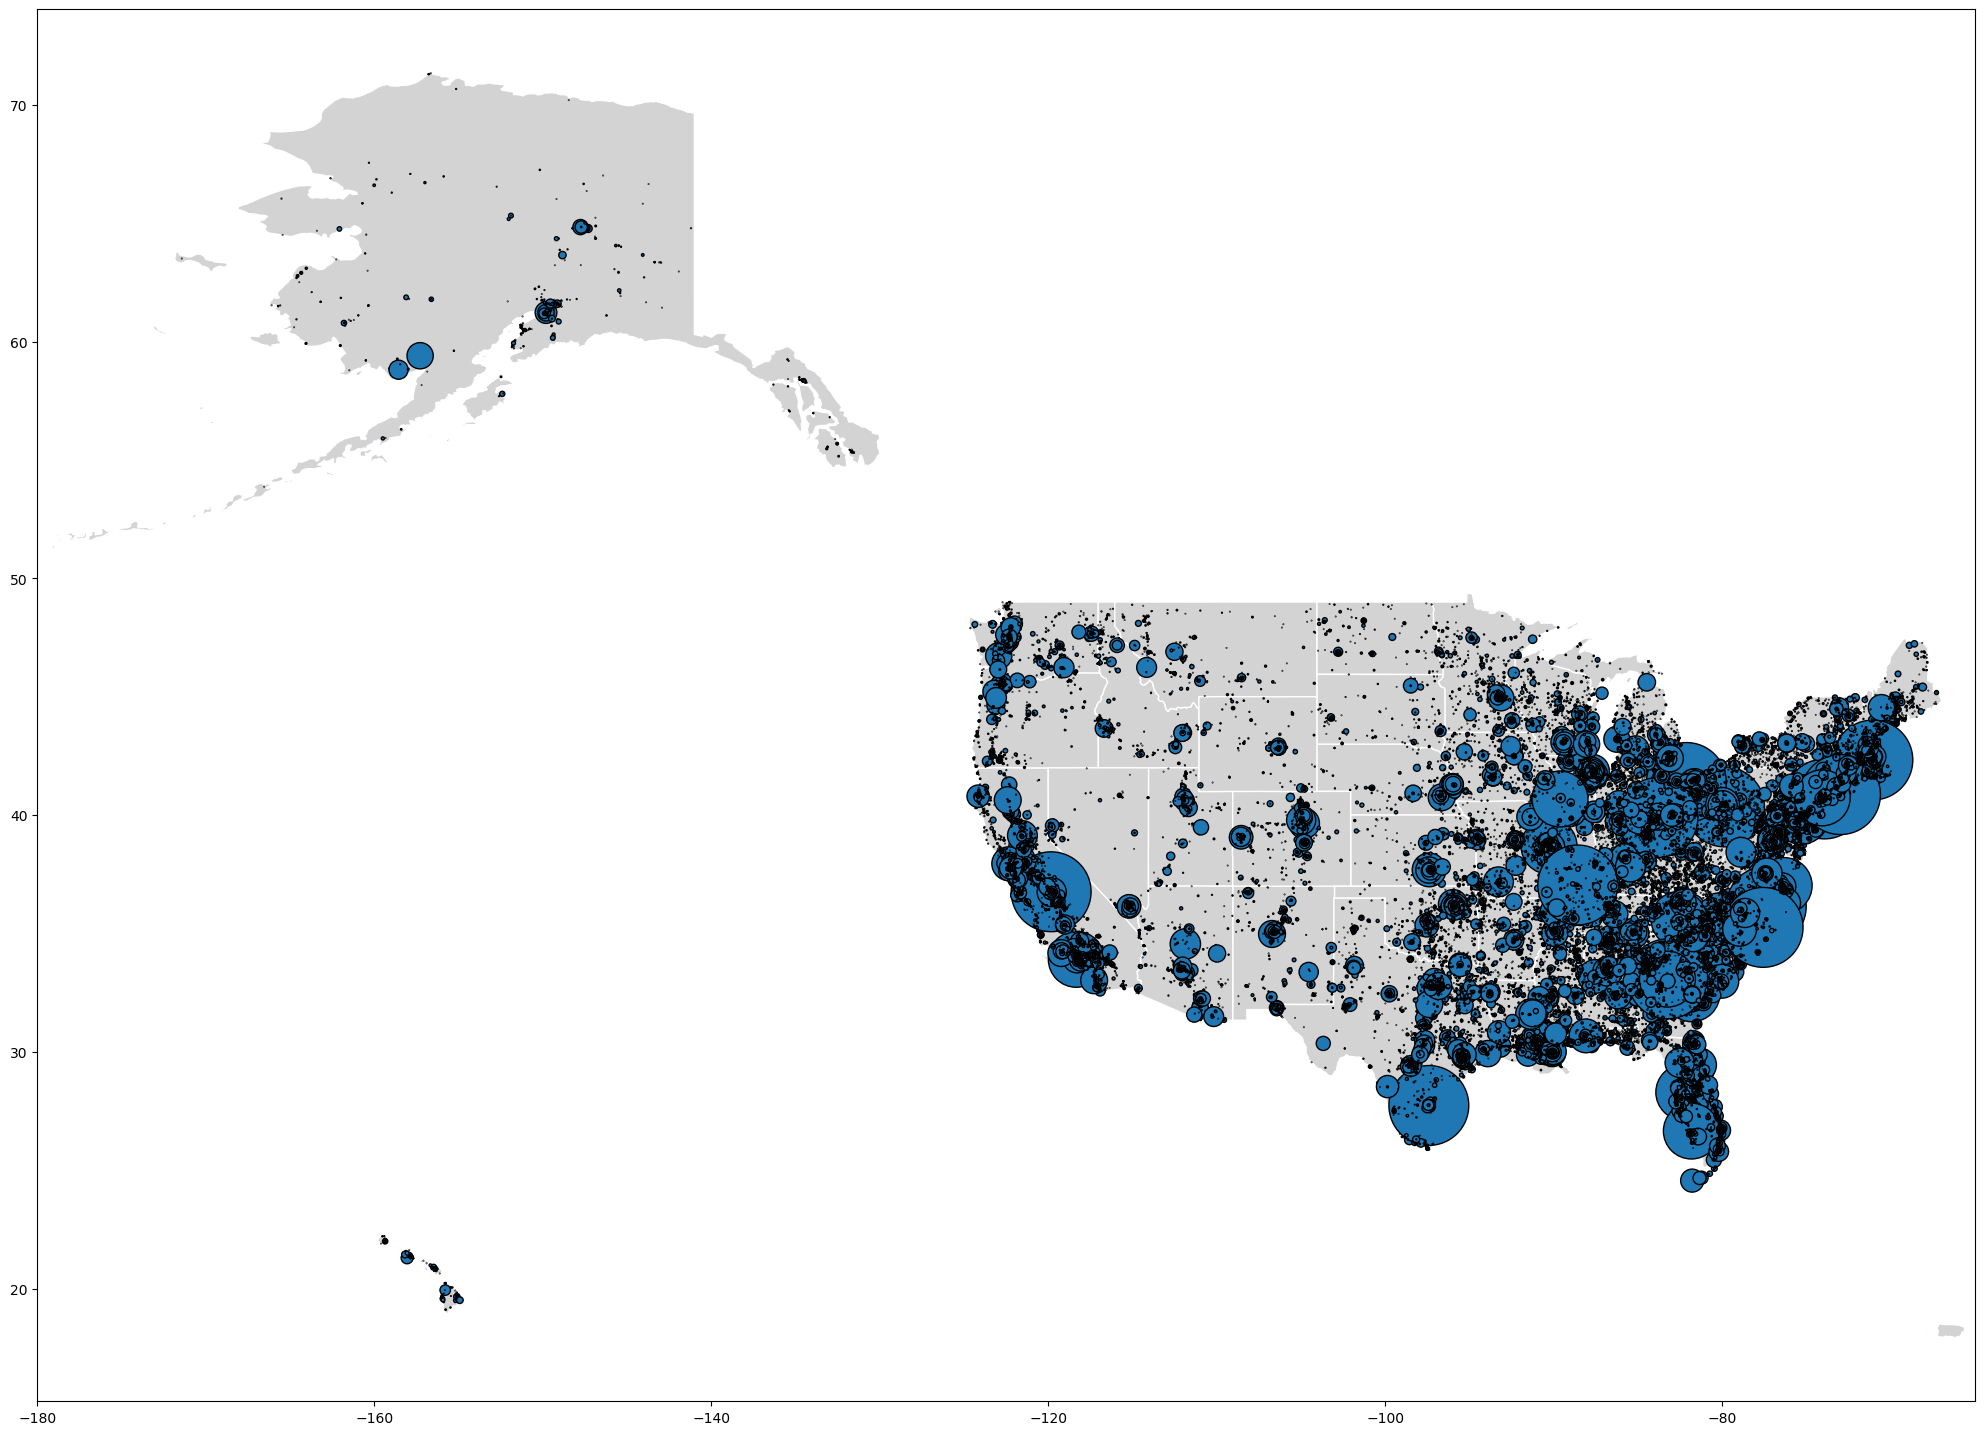

In [192]:
united_states = GeoDataFrame.from_file('state_shapefiles/')
#north_america.plot(color='lightgrey')
axes = united_states.plot(color='lightgrey', edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.15*(gb_city['incident_count']), edgecolors='black')
plt.xlim(xmin=-180,xmax=-65)
plt.show()

## Zoom into continental US

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


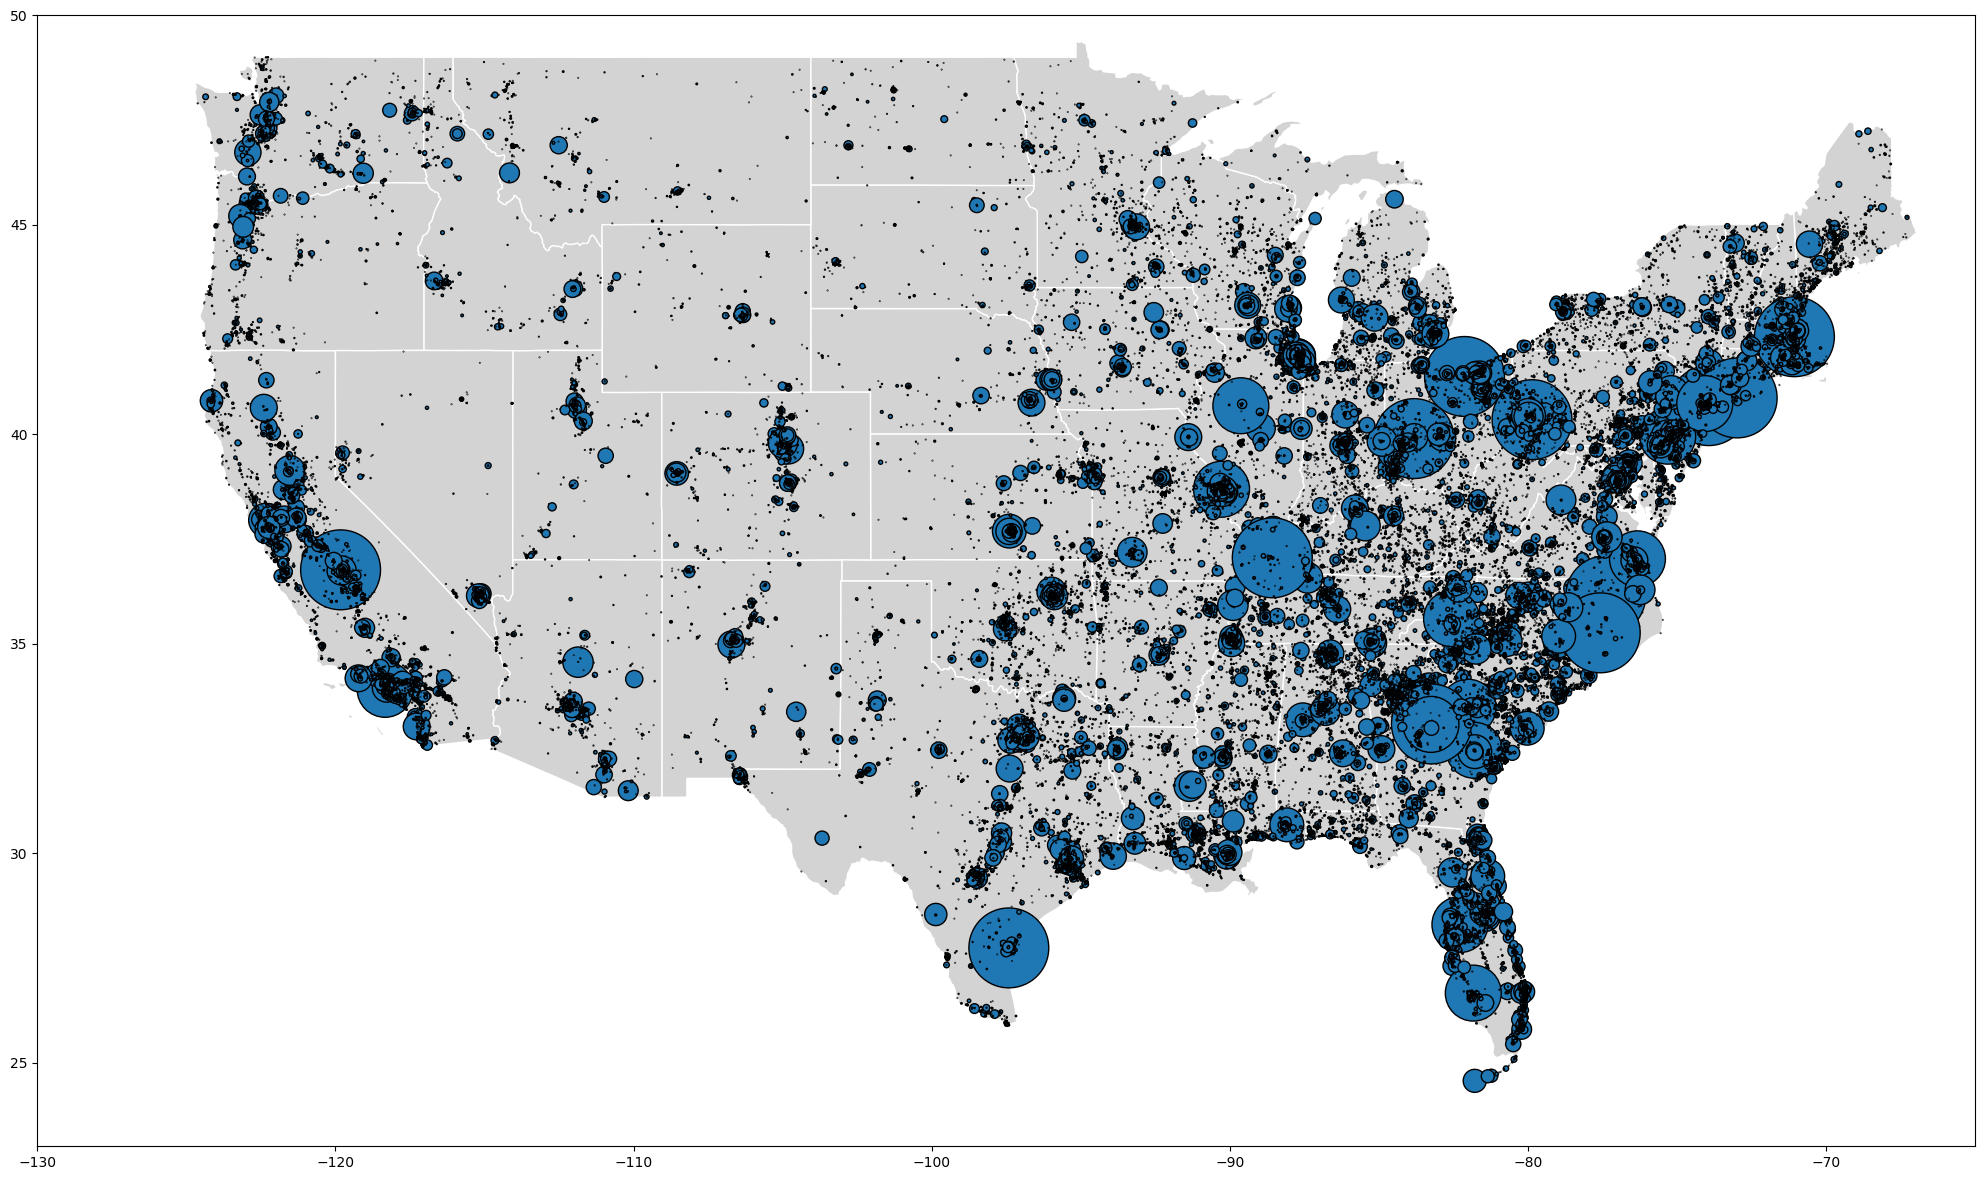

In [191]:
united_states = GeoDataFrame.from_file('state_shapefiles/')
#north_america.plot(color='lightgrey')
axes = united_states.plot(color='lightgrey',edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.15*(gb_city['incident_count']), edgecolors='black')
plt.xlim(xmin=-130,xmax=-65)
plt.ylim(ymin=23, ymax=50)
plt.show()

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


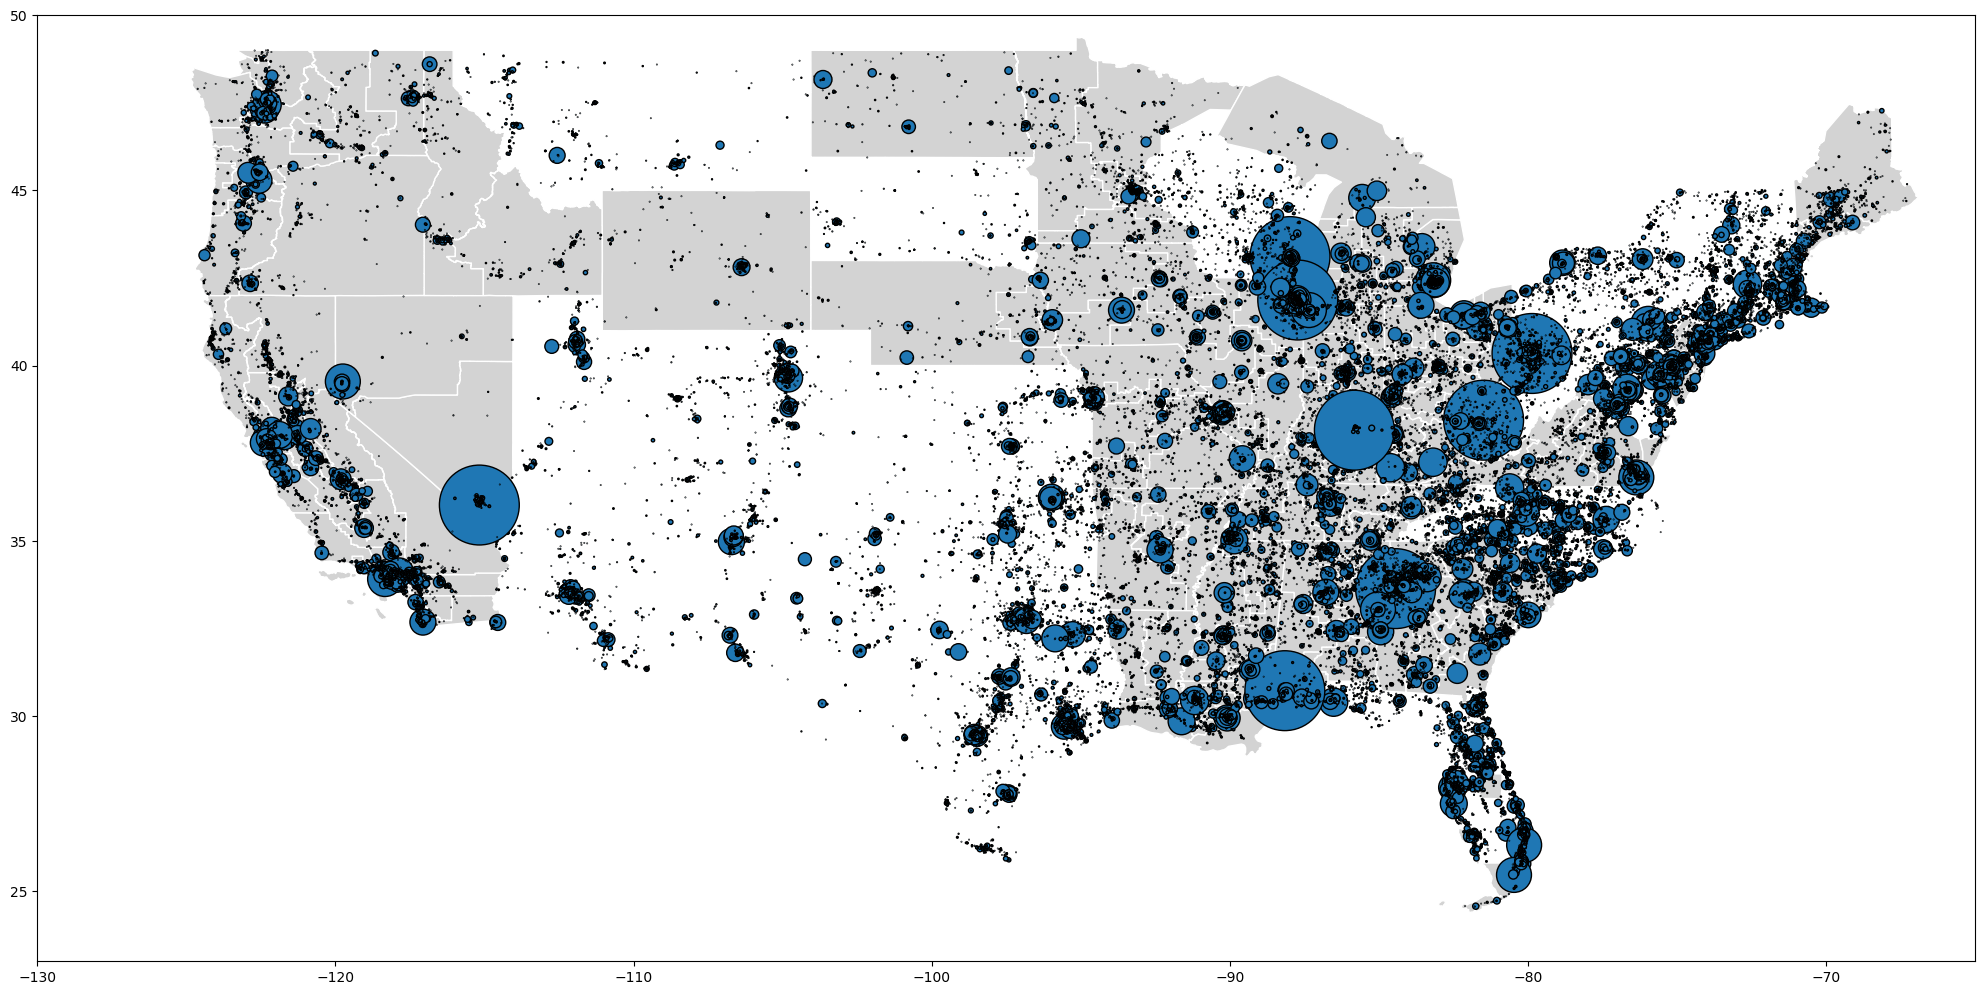

In [195]:
#mapped by congressional districts

united_states = GeoDataFrame.from_file('congressional_district_shapefiles/')
#north_america.plot(color='lightgrey')
axes = united_states.plot(color='lightgrey',edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.15*(gb_cong['incident_count']), edgecolors='black')
plt.xlim(xmin=-130,xmax=-65)
plt.ylim(ymin=23, ymax=50)
plt.show()

In [ ]:
### Parse gun_type column and display histogram of gun type frequency

In [ ]:
###############
# Gun Type
###############
import re
import math

guns_list = []

for item in df['gun_type']:

    if type(item) == float and math.isnan(item):
        continue

    gun = re.findall("\d*::\d* (?P<gun>\w*)", item)

    if len(gun) == 0:
        gun = re.findall("\d*::(?P<gun>\w*)", item)

    guns_list.extend(gun)

# print(guns_list)

plt.xticks(rotation="vertical")
plt.hist(guns_list)
plt.show()

In [ ]:
### Find the 10 most common words listed in the 'incident characteristics' column ###
### The regular expressions is used as a space delimiter, since some of the words ###
### are separated with spaces and others are separated with the "||" symbol ###

import re
from collections import Counter
import pandas as pd

df["incident_characteristics"] = df["incident_characteristics"].astype(str)

# create an empty Counter object
word_counts = Counter()

# loop through each row in the DataFrame
for index, row in df.iterrows():
    # split the "Incident_Characteristics" column into a list of words using a regular expression
    words = re.findall(r'\w+', row['incident_characteristics'])
    # update the Counter object with the words in this row
    word_counts.update(words)

# get the 10 most common words
most_common_words_10 = word_counts.most_common(10)

# print the results
print("The 10 most common words are:")
for word, count in most_common_words_10:
    print(f"{word}: {count}")

In [ ]:
### Creating a word cloud of the most common words. Currently the count is 200, which ###
### feels like enough to get a good sense of the types of descriptive words used in ###
### the reports. ###

most_common_words_200 = word_counts.most_common(200)
most_common_words_dict = dict(most_common_words_200)

wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(most_common_words_dict)

# plot the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# import requests
# from bs4 import BeautifulSoup

# # send a GET request to the webpage and get the HTML content
# url = "https://ballotpedia.org/Colorado_State_Senate"
# response = requests.get(url)
# html_content = response.content

# # create a BeautifulSoup object to parse the HTML content
# soup = BeautifulSoup(html_content, 'html.parser')

# # find the table element that contains the data
# table = soup.find('table', class_='infobox')

# # loop through each row in the table and extract the data
# for row in table.find_all('tr'):
#     # get the columns in this row
#     cols = row.find_all('td')
#     # if there are exactly 4 columns, extract the data and print it
#     if len(cols) == 4:
#         office = cols[0].get_text(strip=True)
#         name = cols[1].get_text(strip=True)
#         party = cols[2].get_text(strip=True)
#         date_assumed_office = cols[3].get_text(strip=True)
#         print(f"{office}: {name}, {party}, {date_assumed_office}")

In [ ]:
# break up Participant Gender
import matplotlib.pyplot as plt

participant_gender = df['participant_gender']
cleaned_row = []

for row in participant_gender:
    regex = 'Male'
    match_males = re.findall(regex, str(row))

    regex = 'Female'
    match_females = re.findall(regex, str(row))

    if match_males != None:
        cleaned_row = cleaned_row + match_males
    if match_females != None:
        cleaned_row = cleaned_row + match_females

plt.hist(cleaned_row)
plt.show()

In [ ]:
participant_type = df['participant_type']
cleaned = []

for parts in participant_type:

    if '||' in str(parts):
        part = str(parts).split('||')
        
        for keyval in part:
            if '::' in str(keyval):
                
                part_value = str(keyval).split('::')
                cleaned.append(part_value[1])

plt.hist(cleaned)
plt.show()

0.0     143654
1.0      60614
2.0      23119
3.0       8032
4.0       2907
5.0        861
6.0        229
7.0         89
8.0         58
10.0        24
9.0         23
15.0        10
11.0        10
13.0         7
12.0         7
14.0         5
20.0         3
16.0         3
19.0         3
21.0         3
24.0         3
29.0         2
52.0         1
17.0         1
28.0         1
27.0         1
18.0         1
23.0         1
35.0         1
63.0         1
22.0         1
30.0         1
32.0         1
Name: suspect_count, dtype: int64


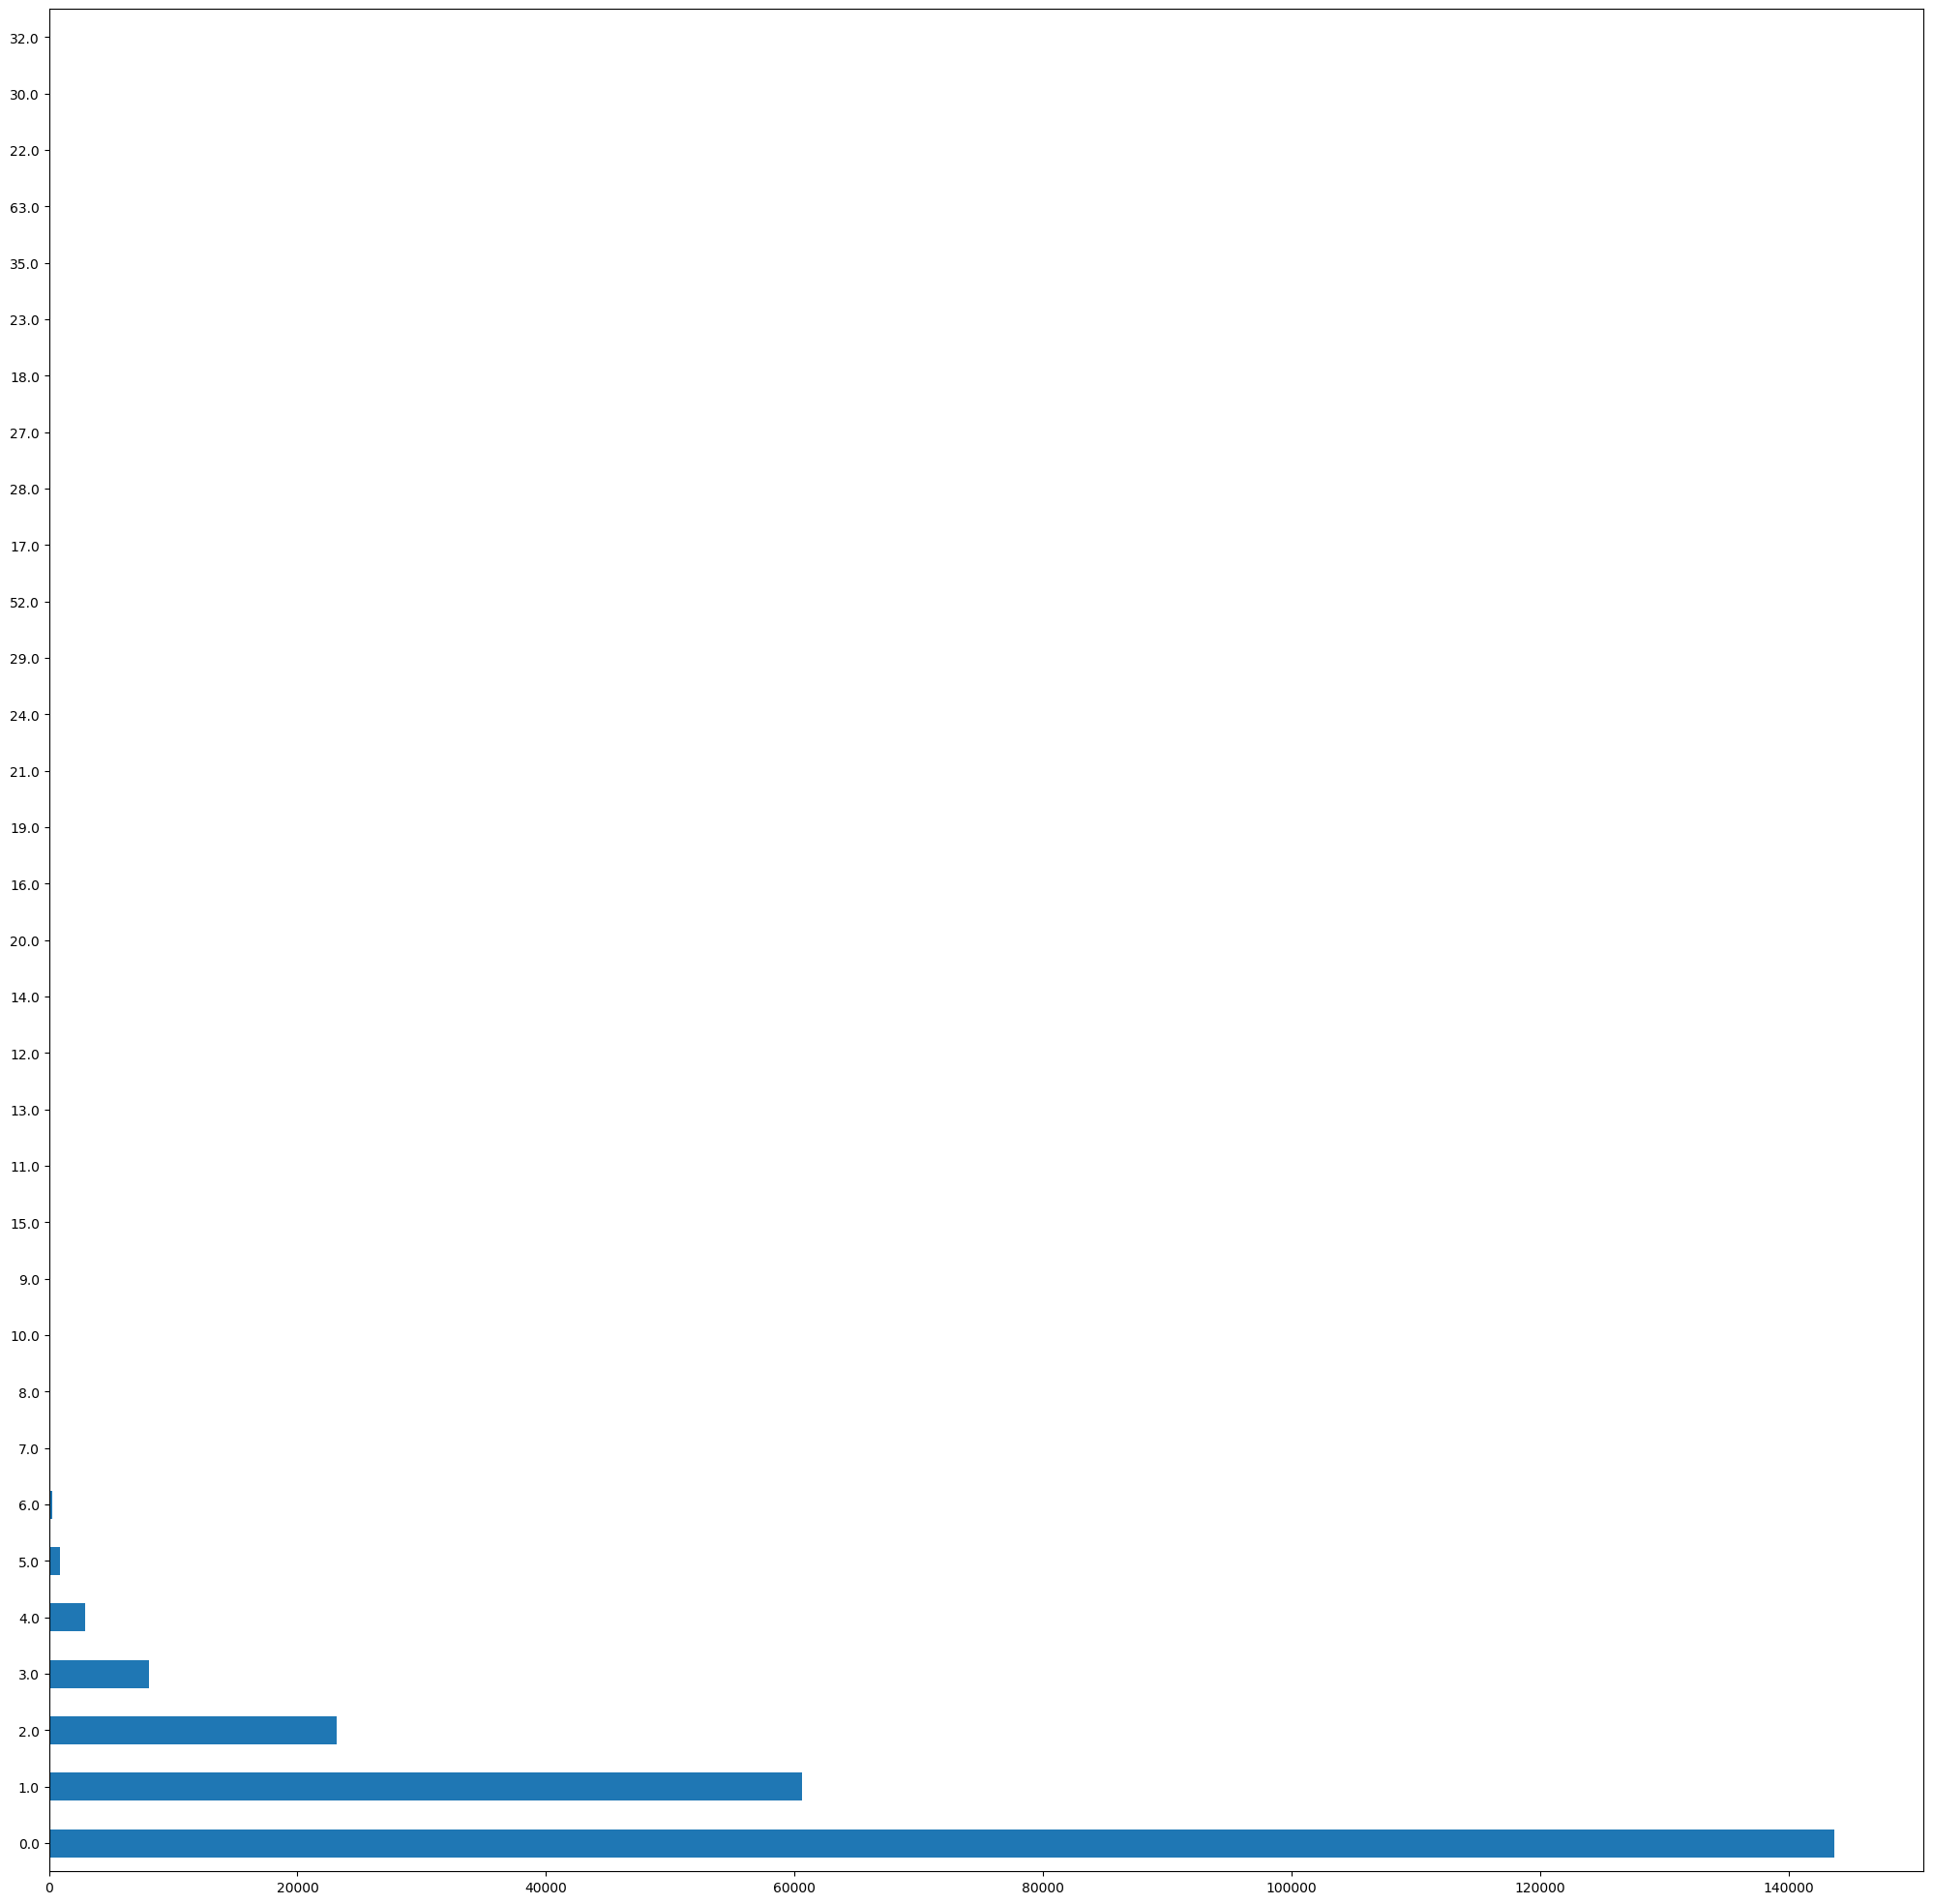

In [98]:
participant_type = df['participant_type']

i = 0

for parts in participant_type:

    suspects = []
    victims = []

    if '||' in str(parts):
        part = str(parts).split('||')
        for keyval in part:
            if '::' in str(keyval):
                part_value = str(keyval).split('::')
                if part_value[1] == 'Victim':
                    victims.append(part_value[1])
                elif part_value[1] == 'Subject-Suspect':
                    suspects.append(part_value[1])

    df.at[i,'victim_count'] = len(victims)
    df.at[i,'suspect_count'] = len(suspects)
    i = i + 1

plt.clf()
#plt.hist(df['suspect_count'], range=[0,7])
print(df['suspect_count'].value_counts())
df['suspect_count'].value_counts().plot(kind='barh')
plt.show()

In [100]:
from collections import Counter

phrases_list = []
count = 0

for i, row in df.iterrows():
    if (row['n_injured'] == 0 and row['n_killed'] == 0):
        count = count + 1
        #print(row['incident_characteristics'])
 
        if not isinstance(row['incident_characteristics'], float):

            incident_text = row['incident_characteristics']
            
            if '||' in str(incident_text):
                item = str(incident_text).split('||')
                
                for phrases in item:
                    phrases_list.append(phrases)


print("Number of incidents where injured = 0 and killed = 0: %d" % count)
print("Total rows in dataframe: %d" % len(df))
print("Percentage of none injured and none killed: %f" % (count/len(df)))


most_common_words_20 = Counter(phrases_list).most_common(25)
print("\n\n25 Most Common Phrases in Incident Characteristics column:")
for word, count in most_common_words_20:
    print(f"{word}: {count}")

Number of incidents where injured = 0 and killed = 0: 97287
Total rows in dataframe: 239677
Percentage of none injured and none killed: 0.405909


25 Most Common Phrases in Incident Characteristics column:
Non-Shooting Incident: 42753
Possession (gun(s) found during commission of other crimes): 23658
Shots Fired - No Injuries: 18949
ATF/LE Confiscation/Raid/Arrest: 16397
Brandishing/flourishing/open carry/lost/found: 13771
Drug involvement: 12785
Possession of gun by felon or prohibited person: 12450
Officer Involved Incident: 7630
Institution/Group/Business: 7251
Stolen/Illegally owned gun{s} recovered during arrest/warrant: 6575
Armed robbery with injury/death and/or evidence of DGU found: 5787
Home Invasion: 5152
Gun(s) stolen from owner: 5107
Home Invasion - No death or injury: 4950
Drive-by (car to street, car to car): 4192
Officer Involved Incident - Weapon involved but no shots fired: 3780
Car-jacking: 3370
Domestic Violence: 3168
Officer Involved Shooting - Shots fired, no inju

In [102]:
# Data Preprocessing - Get ZIP CODE
# assigns to new 'zipcode' column in dataframe

!pip install geopy
import geopy
import pandas as pd

#longlat = pd.read_csv("longlat.csv",encoding = 'utf-8', sep = '\t')
geolocator = geopy.Nominatim(user_agent="check_1")

def get_zip_code(x):
    location = geolocator.reverse("{}, {}".format(x['latitude'],x['longitude']))
    return location.raw['address']['postcode']

df['zipcode'] = df.head().apply(lambda x: get_zip_code(x), axis = 1)
print(df.head(5))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 kB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 844.6 kB/s eta 0:00:00a 0:00:01
   incident_id        date           state city_or_county  \
0       461105  2013-01-01    Pennsylvania     Mckeesport   
1       460726  2013-01-01      California      Hawthorne   
2       478855  2013-01-01            Ohio         Lorain   
3       478925  2013-01-05        Colorado         Aurora   
4       478959  2013-01-07  North Carolina     Greensboro   

                                     address  n_killed  n_injured  \
0  1506 Versailles Avenue and Coursin Street         0          4   
1               13500 block of Cerise Avenue         1          3   
2                      1776 East 28th Street         1          3   
3           16000 block of East Ithaca Place         4          0   
4                  307 Mourning Dove Terrace         2          2   

                                      